In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import datetime
import random
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.grid_search import GridSearchCV

import utils as ut
from utils import RET_PER, FIG_WIDTH, FIG_HEIGHT, TARGET_SERIES, TARGET_INDICATOR

sns.set_context("paper")

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
tar = ut.load_target()
PANEL_SCORE = True

## increasing values

In [4]:
series = 'IV'
px, px_ca, px_us = ut.load_series(series)

int: 6.680597718556747e-16	coef: 0.5432397473141669


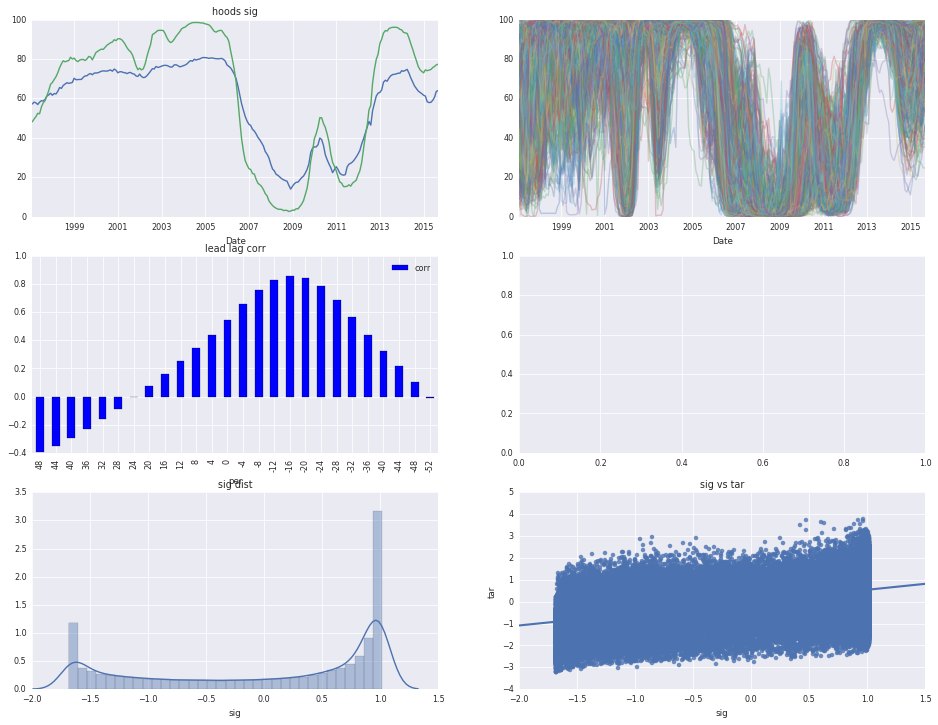

In [5]:
ut.explore_series(px, px_ca, px_us, tar)

## decreasing values

In [6]:
series = 'DV'
px, px_ca, px_us = ut.load_series(series)

int: -9.718442216643209e-15	coef: -0.5394021201205453


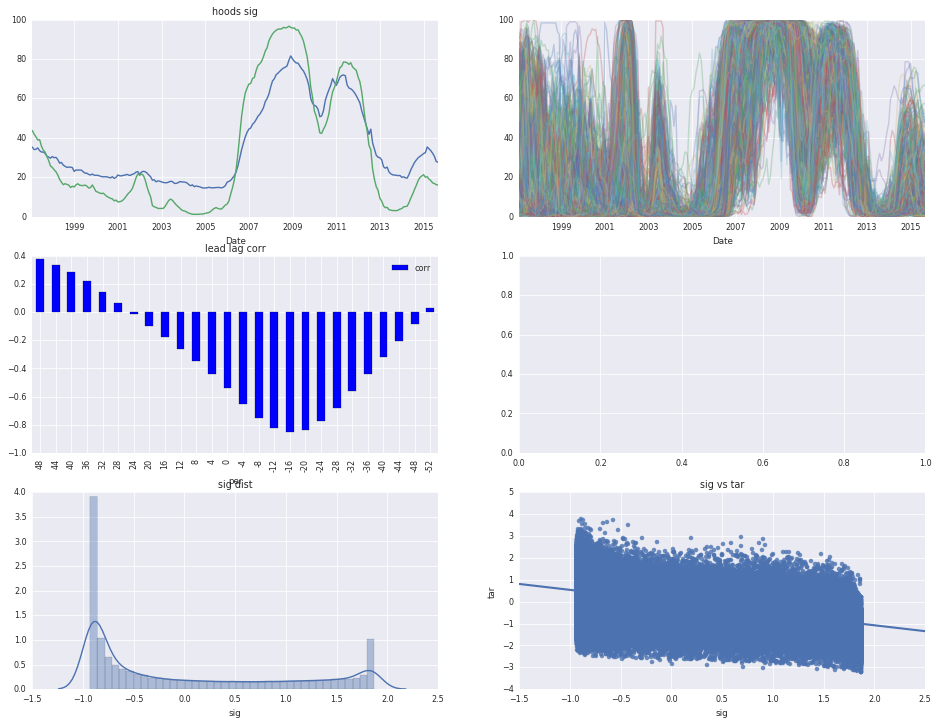

In [7]:
ut.explore_series(px, px_ca, px_us, tar)

## ratio sales price to list price

In [8]:
series = 'SLPR'
px, px_ca, px_us = ut.load_series(series)

In [9]:
px

,00003,00004,00007,00014,00021,00025,00032,00034,00035,00037,...,01028,01145,01213,01535,01987,02046,02637,04463,04531,05903
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-28,0.9954,0.99,0.9937,0.9801,0.9857,0.9987,0.9783,0.9757,0.9872,1.0667,...,0.9734,0.9812,1,0.9747,0.9699,0.9608,0.993141,1.0821,0.9697,0.9956


## turnover in housing market in past year

In [10]:
series = 'SPY'
px, px_ca, px_us = ut.load_series(series)

int: -4.636005344933758e-15	coef: 0.12150467813012468


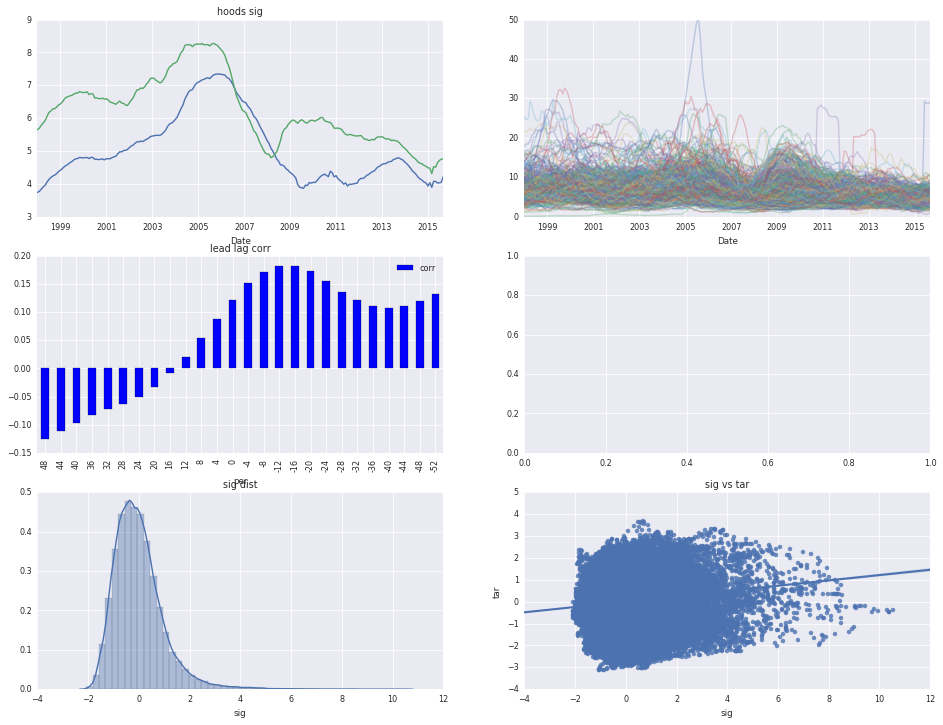

In [11]:
ut.explore_series(px, px_ca, px_us, tar)

## sold for gain

In [12]:
series = 'SFG'
px, px_ca, px_us = ut.load_series(series)

In [13]:
yoy = lambda x: x / x.shift(24) - 1.
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
SFG_c = px

int: 6.420580631653806e-15	coef: 0.2209987145836032


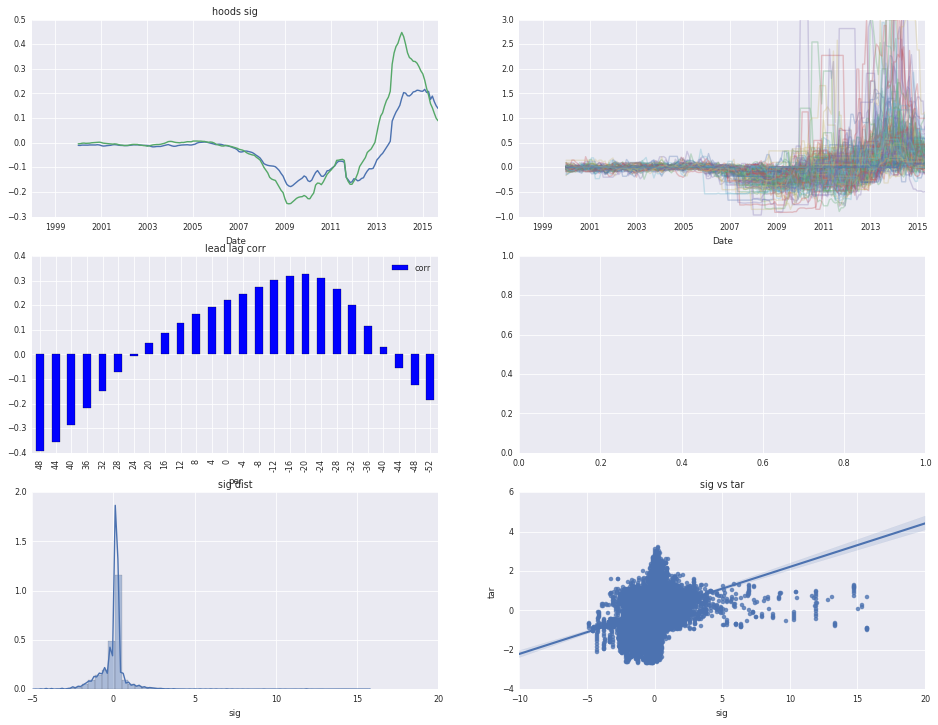

In [14]:
ut.explore_series(px, px_ca, px_us, tar)

# price per square foot

In [15]:
series = 'MVSF'
px, px_ca, px_us = ut.load_series(series)

In [16]:
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
MVSF_c = px

int: -1.1361756881841824e-14	coef: 0.34716797412193345


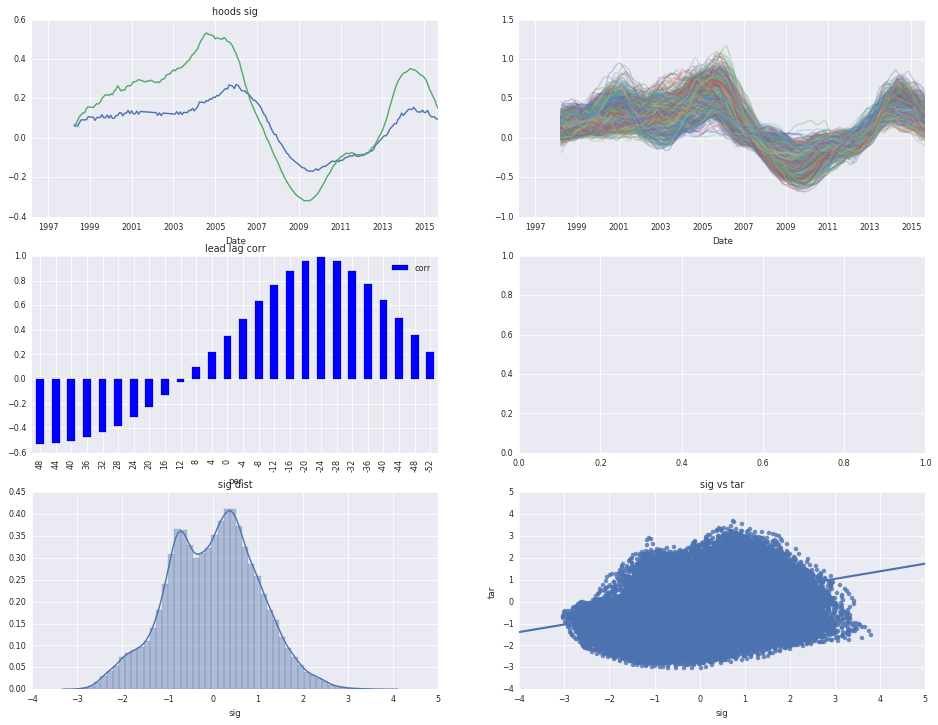

In [17]:
ut.explore_series(px, px_ca, px_us, tar)

# momentum

In [18]:
px, px_ca, px_us = ut.load_series(TARGET_SERIES)

In [19]:
px, px_ca, px_us = ut.capped_transformation(ut.momentum, px, px_ca, px_us)
TAR_mom = px

int: -2.0877090474233895e-14	coef: 0.3292697143381802


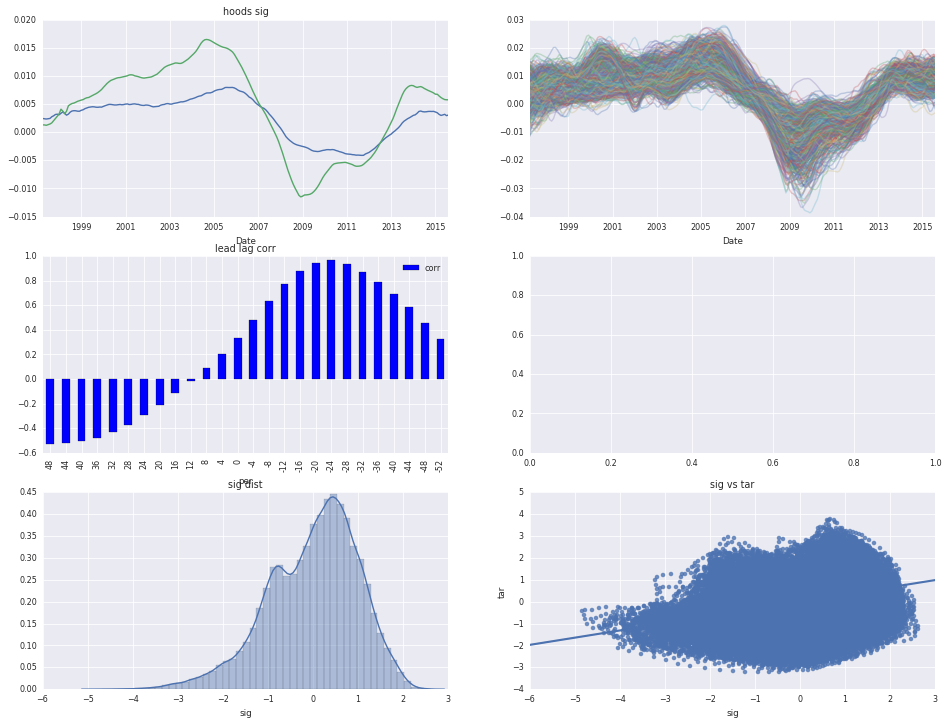

In [20]:
ut.explore_series(px, px_ca, px_us, tar)

# change in momentum

In [21]:
px, px_ca, px_us = ut.load_series(TARGET_SERIES)

In [22]:
def momentum_change(df):
        mom_cur = ut.momentum(df)
        mom_prev = ut.momentum(df.shift(12))
        return (mom_cur - mom_prev).dropna(how='all')

In [23]:
px, px_ca, px_us = ut.capped_transformation(momentum_change, px, px_ca, px_us)
TAR_mom_chg = px

int: -8.526579902231845e-15	coef: 0.5485486229227057


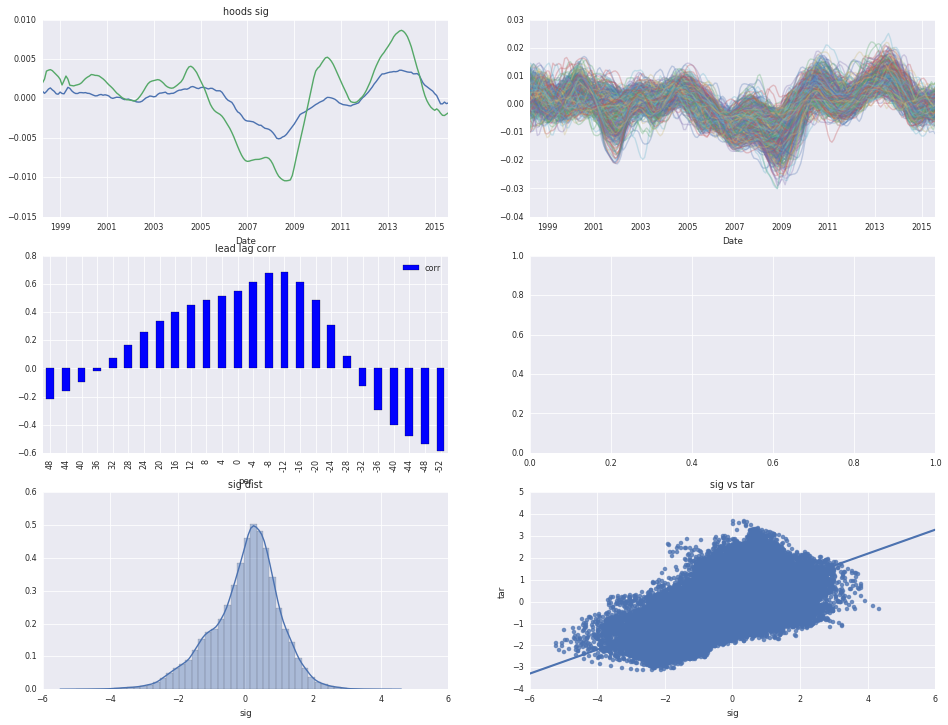

In [24]:
ut.explore_series(px, px_ca, px_us, tar)

## build model

In [25]:
features = {}
for i in ('IV', 'DV', 'SPY'):
    features[i] = ut.load_quandl_data('hoods', i)
features['tar'] = tar
features['SFG'] = SFG_c
features['MVSF'] = MVSF_c
features['TAR_mom'] = TAR_mom
features['TAR_mom_chg'] = TAR_mom_chg

df = ut.stack_and_align(features.values(), cols=features.keys()).dropna()

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


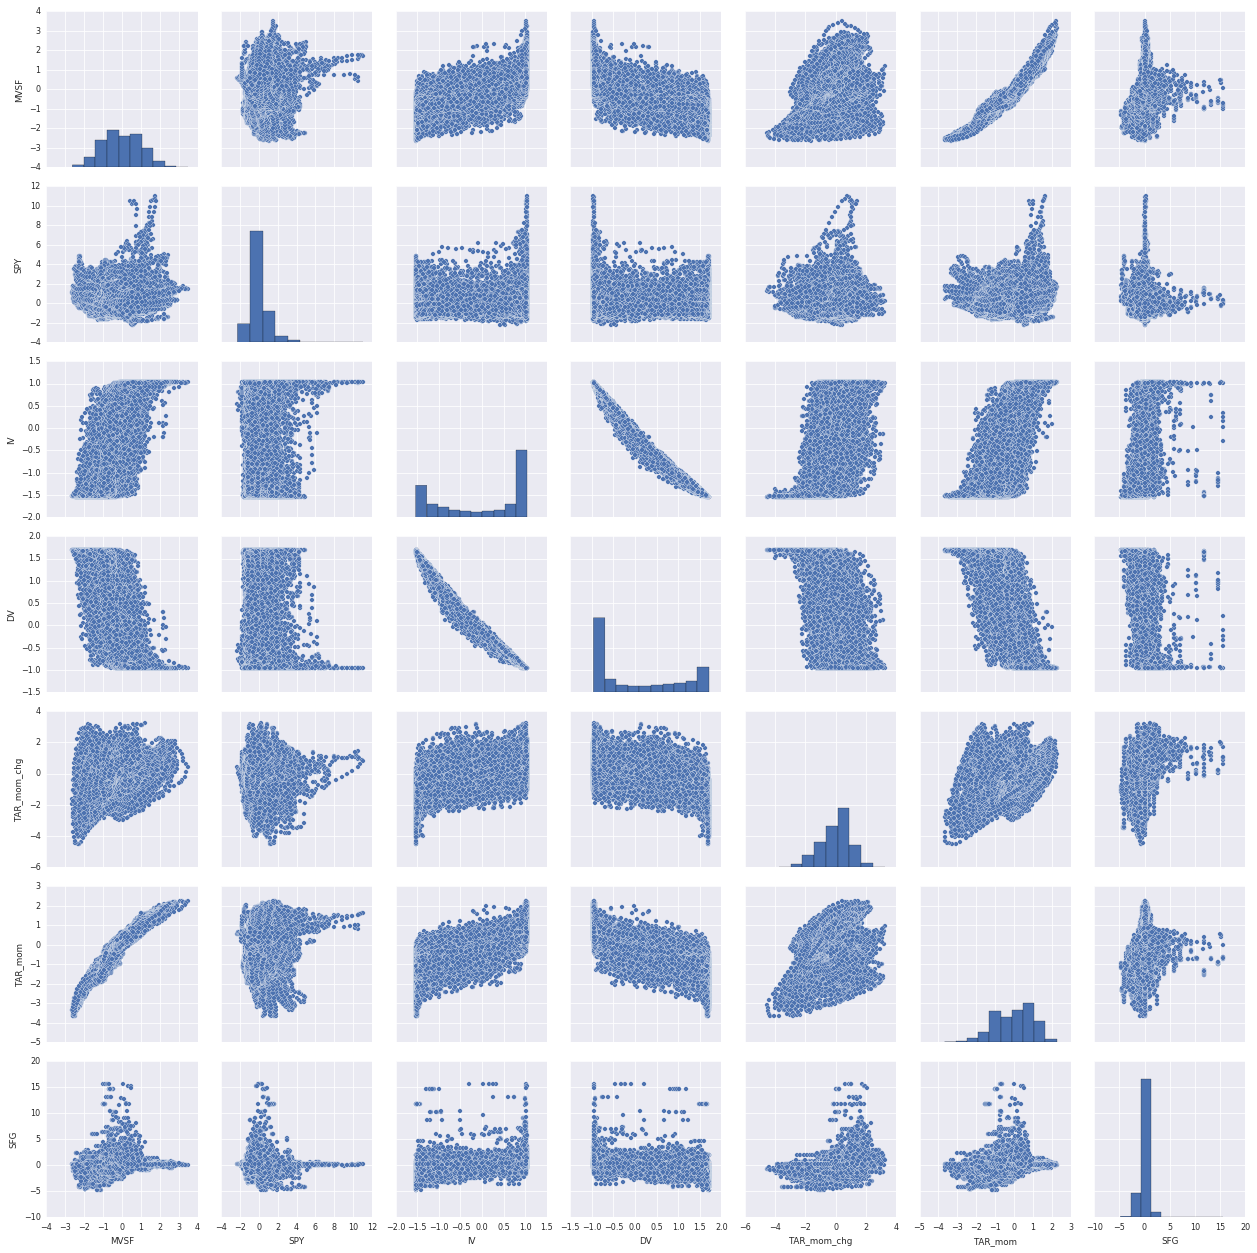

In [26]:
sns.pairplot(ut.ts_score(df[[c for c in df.columns if c != 'tar']], panel=PANEL_SCORE))

sharpe ratios:
0.2    1.017426
0.4    1.616859
0.6    2.029084
0.8    2.282521
1.0    2.273418
mkt    1.639003
dtype: float64
r2: 0.3341499016227668	int: 6.910588380223066e-15	coef: [ 0.04383852 -0.00350961  0.11154117 -0.10488819  0.16822752  0.02780744
  0.03113983]	alpha: 50000


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


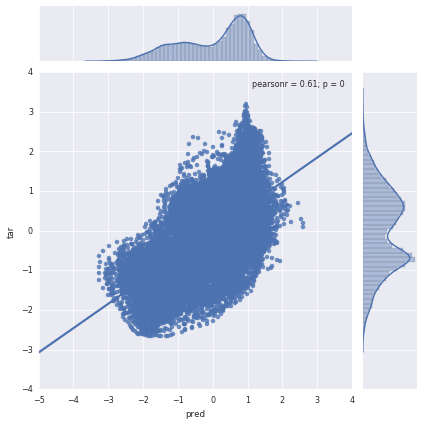

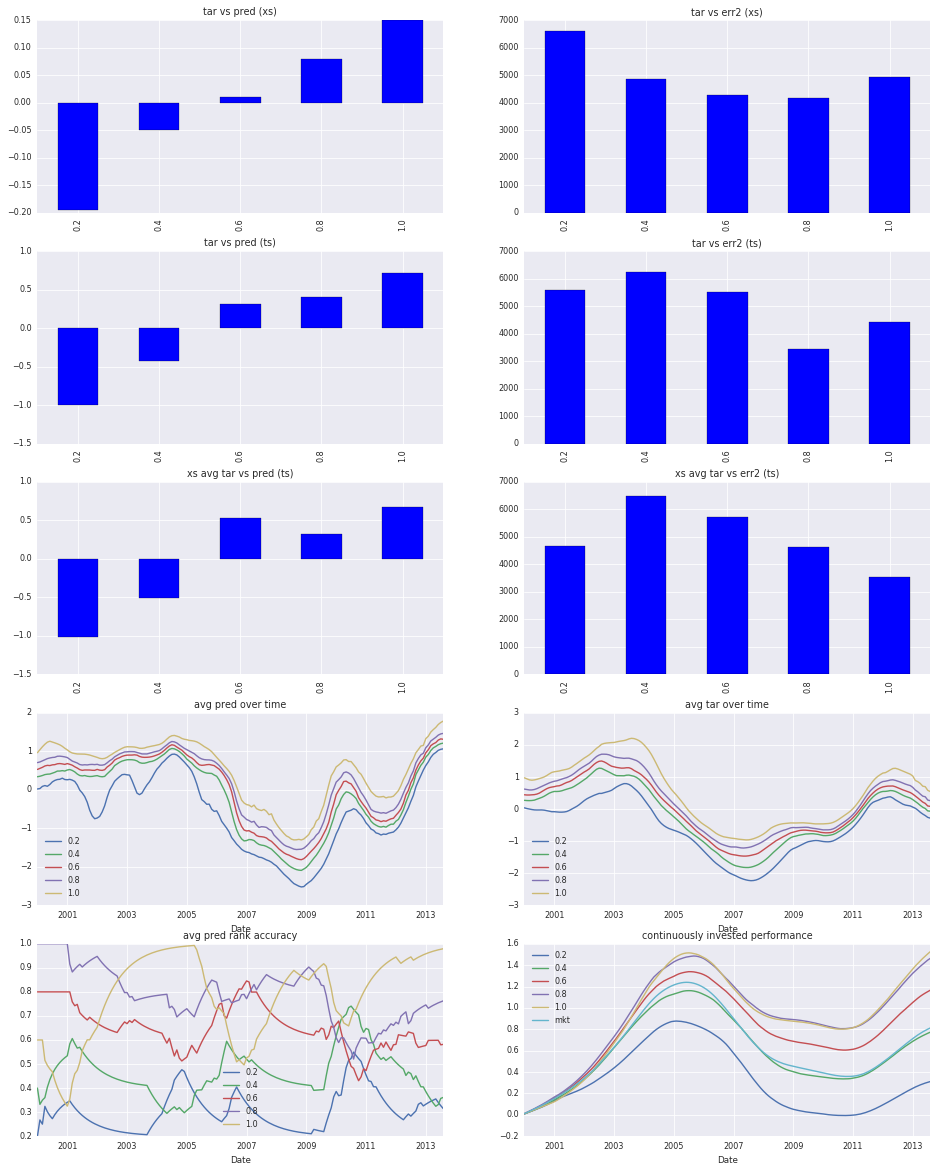

In [27]:
clf = lm.RidgeCV(alphas=[1., 10., 100, 1000, 10000, 50000, 10000000], cv=5)
clf, df_res, score = ut.build_model(clf, df, PANEL_SCORE)
print
print('r2: {2}\tint: {0}\tcoef: {1}\talpha: {3}'.format(clf.intercept_, clf.coef_, score, clf.alpha_))

sharpe ratios:
0.2    0.958072
0.4    1.578525
0.6    2.029079
0.8    2.301360
1.0    2.362357
mkt    1.639003
dtype: float64
r2: 0.3950336963431529	int: 6.587303803335423e-15	coef: [ 0.         -0.          0.25644163 -0.          0.33271486  0.          0.        ]	alpha: 0.1


/home/condauser/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/base.py:400: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':
/home/condauser/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/base.py:400: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':
/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


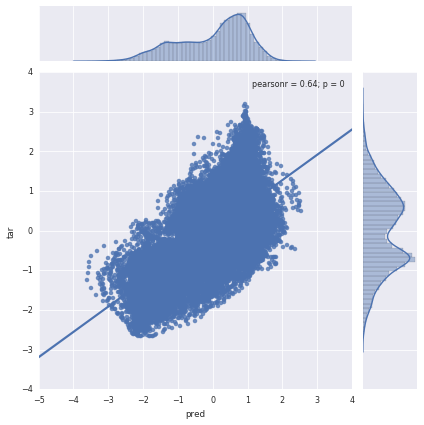

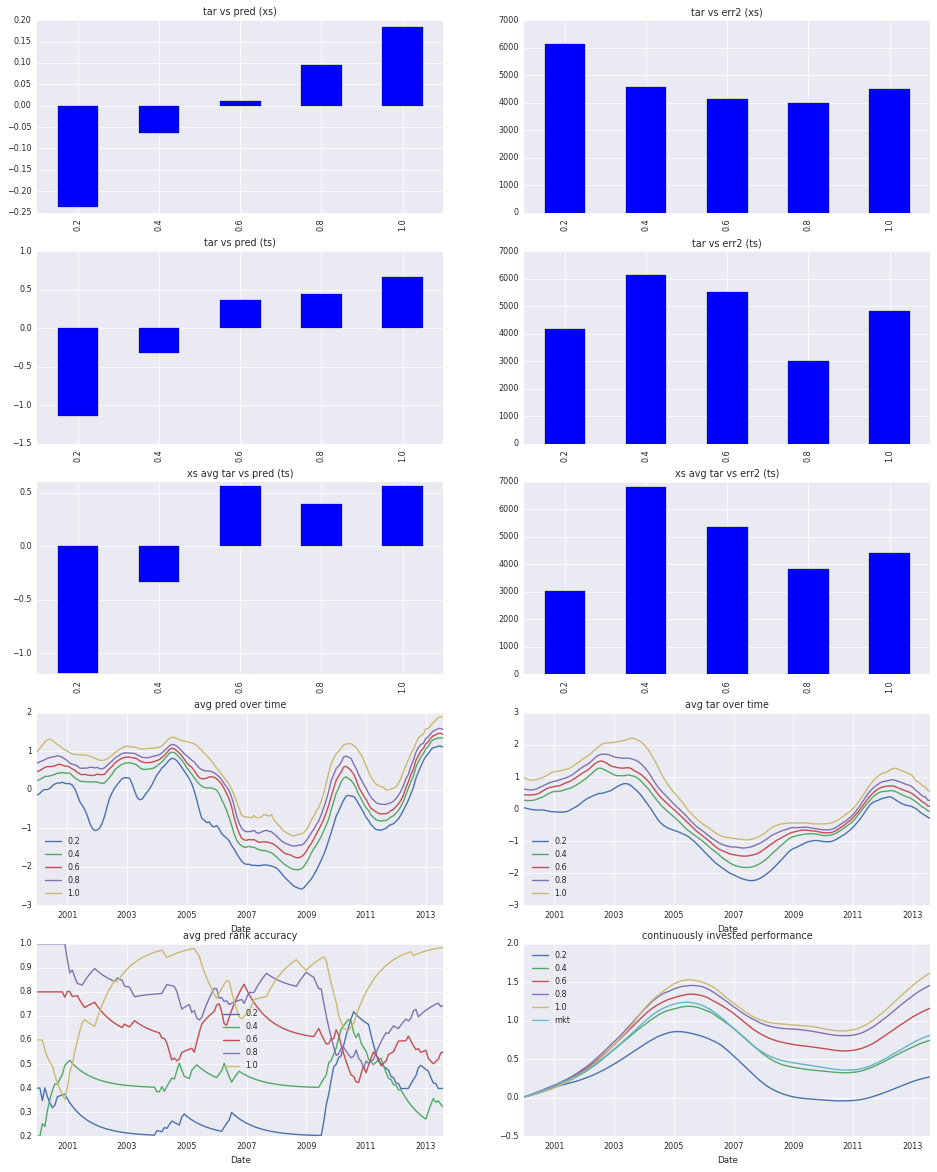

In [28]:
clf = lm.LassoCV(alphas=[.0001, .001, .01, .1], cv=5)
clf, df_res, score = ut.build_model(clf, df, PANEL_SCORE)
print
print('r2: {2}\tint: {0}\tcoef: {1}\talpha: {3}'.format(clf.intercept_, clf.coef_, score, clf.alpha_))

sharpe ratios:
0.2    2.223793
0.4   -0.386416
0.6    0.865346
0.8   -5.851265
1.0   -5.391459
mkt    1.376810
dtype: float64
r2: 0.48454440113586406
DecisionTreeRegressor(compute_importances=None, criterion='mse', max_depth=2,
           max_features=1, max_leaf_nodes=None, min_density=None,
           min_samples_leaf=1, min_samples_split=2, random_state=None,
           splitter='best')


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


TypeError: startswith first arg must be str or a tuple of str, not bytes

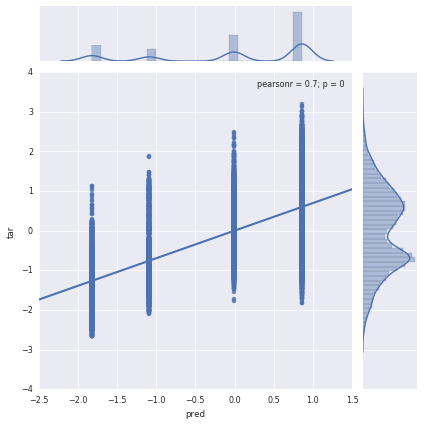

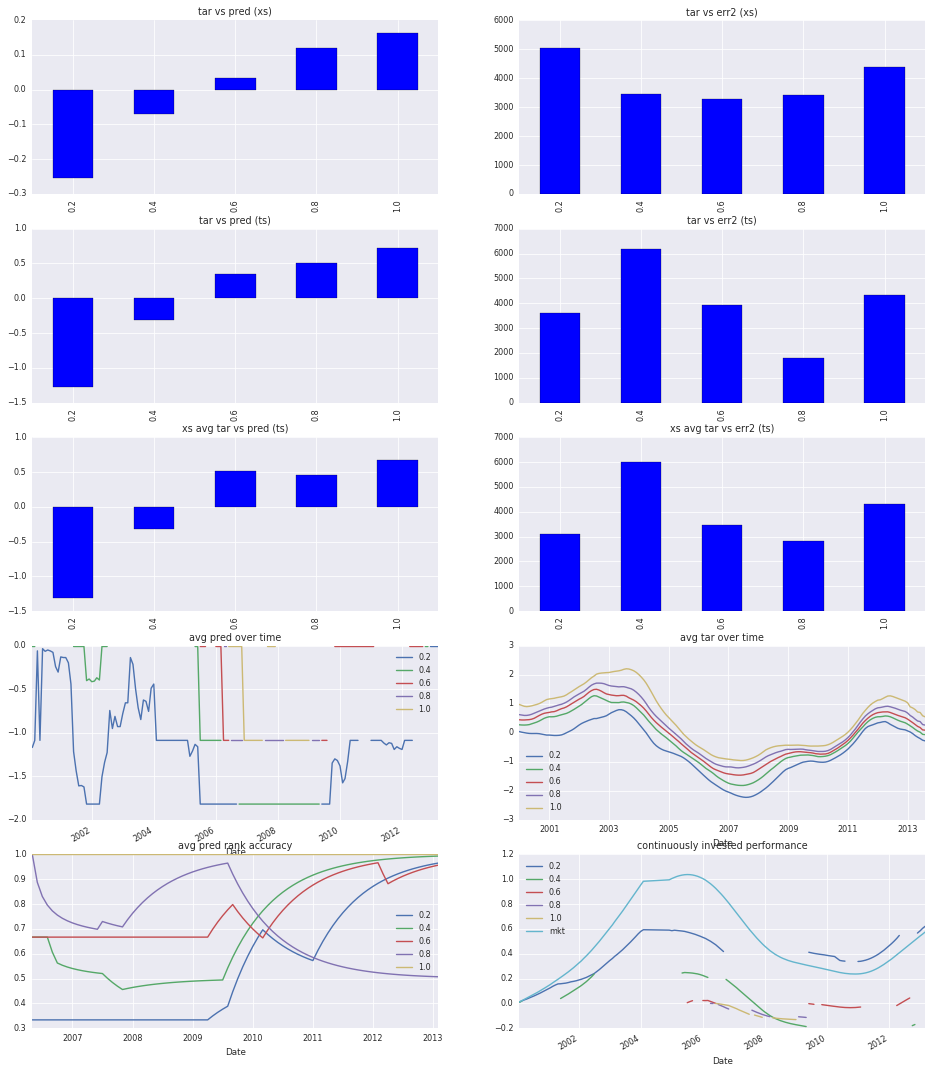

In [30]:
clf = GridSearchCV(tree.DecisionTreeRegressor(), param_grid={'max_depth': [2,3,5], 'max_features': [None, 1, 2]}, cv=5)
clf, df_res, score = ut.build_model(clf, df, PANEL_SCORE)
print
print('r2: {0}'.format(score,))
print(clf.best_estimator_)
ut.tree_vis(clf.best_estimator_)

# why does this score show differently based on whether preds are ts scored?

In [ ]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=100), param_grid={'max_depth': [2,3,5,7], 'max_features': [None, 1, 2, 4]}, cv=5, n_jobs=1)
clf, df_res, score = ut.build_model(clf, df, PANEL_SCORE)
print
print('r2: {0}'.format(score,))
clf.best_estimator_

In [ ]:
(pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))

In [ ]:
clf = GridSearchCV(GradientBoostingRegressor(), param_grid={'n_estimators': [50, 200],
                                                            'max_depth': [1,3,5], 
                                                            'max_features': [None, 1, 2]}, 
                   cv=5, n_jobs=2)
clf, df_res, score = ut.build_model(clf, df, PANEL_SCORE)
print
print('r2: {0}'.format(score,))
clf.best_estimator_

In [ ]:
(pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))